In [ ]:
# added a parse_dates line for events df when importing so we don't have to do that separately:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

Here we import the data from the appropiate folder. This is different for the two members of the team so we wrapped it in a try block to account for this difference.

In [49]:
try:
    app_events = pd.read_csv('../talkingdata_DATA/app_events.csv')
    brand_df = pd.read_csv('../talkingdata_DATA/phone_brand_device_model.csv')
    label_categories = pd.read_csv('../talkingdata_DATA/label_categories.csv')
    app_labels = pd.read_csv('../talkingdata_DATA/app_labels.csv')
    events = pd.read_csv('../talkingdata_DATA/events.csv', parse_dates=['timestamp'])
    gender_age_train = pd.read_csv('../talkingdata_DATA/gender_age_train.csv')
    gender_age_test = pd.read_csv('../talkingdata_DATA/gender_age_test.csv')
except FileNotFoundError:
    app_events = pd.read_csv('data/app_events.csv', nrows = 1000000)
    brand_df = pd.read_csv('data/phone_brand_device_model.csv')
    label_categories = pd.read_csv('data/label_categories.csv')
    app_labels = pd.read_csv('data/app_labels.csv')
    events = pd.read_csv('data/events.csv', parse_dates=['timestamp'], nrows = 1000000)
    gender_age_train = pd.read_csv('data/gender_age_train.csv')
    gender_age_test = pd.read_csv('data/gender_age_test.csv')

In [26]:
#brand_df = pd.read_csv('../talkingdata_DATA/phone_brand_device_model.csv')
#label_categories = pd.read_csv('../talkingdata_DATA/label_categories.csv')

To get a feeling of how the data is structured we show the first rows for each dataframe

In [3]:
display(gender_age_train.head()) # want to predict group, involves multiclass classification

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [4]:
display(app_events.head()) # event_id corresponds to that in events dataframe

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [5]:
display(events.head())
display(brand_df.head())

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


#### Remove all device_ids in training data for which there is no event data:

In [70]:
gender_age_train = gender_age_train[gender_age_train.device_id.isin(events.device_id)]

In [76]:
# reset the index
gender_age_train.reset_index(drop=True, inplace=True)

In [242]:
app_events[~app_events.event_id.isin(events.event_id)]

,event_id,app_id,is_active


### Clean phone brand dataframe (brand_df)

In [6]:
display(brand_df.head()) # dataframe pre-cleanup

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


As part of the cleanup we drop possible duplicate entries and (ALEX: dont fully understand whats happening here with the reset_index)

Katherine's explanation (can remove once understood)
    1. drop the duplicates in phone brand column to get only unique values, but then want consecutive values associated with each brand, so reset index with drop=True just resets the index and doesn't keep the old one, then the second reset_index() call changes that new consecutive index into a column (easier to use a column than the index itself sometimes)
    2. Set the index which we turned into a column to be titled phone_brand_id, giving us a df with consecutive values associated with each brand (could be a simpler way to do this with set or list, but this worked fine)

Here we create a dictionary mapping every phone brand to an integer that we can refer back to:

In [50]:
# dictionary of brand categories and their associated numbers/indices
brand_categories = brand_df[['phone_brand']].drop_duplicates().reset_index(drop=True).reset_index()
brand_categories = brand_categories.rename(columns = {'index': 'phone_brand_id'})

We do the same for the device models:

In [51]:
device_categories = brand_df[['device_model']].drop_duplicates().reset_index(drop=True).reset_index()
device_categories = device_categories.rename(columns = {'index':'device_model_id'})
# want a number for each phone-brand, not chinese name

In [52]:
# want a number for each phone-brand, not chinese name
brand_df = brand_df.merge(brand_categories, on='phone_brand')
brand_df = brand_df.merge(device_categories, on='device_model')
brand_df.drop(['device_model','phone_brand'], inplace=True, axis=1)
#brand_df.sort_values('device_id', inplace=True)

In [53]:
display(brand_df.head())

,device_id,phone_brand_id,device_model_id
0,-8890648629457979026,0,0
1,3933889243973057197,0,0
2,3379712123596745643,0,0
3,-5817422246078672037,0,0
4,-5926490704406813688,0,0


Look at breakdown of top 5 phone brands ('Proportion' represents the proportion of total devices that belong to that particular phone brand) and map them back to original Chinese names just to see if any stick out:

In [54]:

phone_brand_counts = brand_df.phone_brand_id.value_counts(normalize=True).rename_axis(
    'phone_brand_id').reset_index(name='proportion').merge(brand_categories,
                                                       on='phone_brand_id')
phone_brand_counts.head(5) # top 10 phone brands

,phone_brand_id,proportion,phone_brand
0,0,0.230767,小米
1,1,0.183108,三星
2,3,0.173911,华为
3,4,0.076878,vivo
4,8,0.076312,OPPO


### App Labels: Put into subcategories

Load in already processed category table (category_df.csv):
The processing took place in EDA_Katherine

In [55]:
category_df = pd.read_csv('category_df.csv')

The category_df contains every label in column 'labels' associated with its edited revised label in 'revised_labels' (e.g. all labels containing the word 'game' are revised to just 'game' and spelling errors are fixed), and the 
general category (found using NLP) is in 'general_category'.

In [56]:
category_df.head()

,Unnamed: 0,labels,revised_labels,general_category
0,0,japanese comic and animation,japanese comic and animation,comic
1,1,P2P net loan,P2P net loan,finance
2,2,online shopping navigation,online shopping navigation,shopping
3,3,Taiwan,Taiwan,travel
4,4,basketball,basketball,entertainment


In [57]:
# merge the new information into the original label_categories dataframe
label_categories.rename(columns = {'category': 'labels'}, inplace=True)
label_categories = label_categories.merge(category_df[['labels','general_category']], on='labels', how='outer')
label_categories.fillna(value={'general_category': 'other'}, inplace=True)

In [58]:
# show those entries that are NaN being classified as 'other'
label_categories[label_categories.labels.isna()]

,label_id,labels,general_category
0,1,NaN,other
1,248,NaN,other
2,264,NaN,other


### Examine breakdown of app categories:

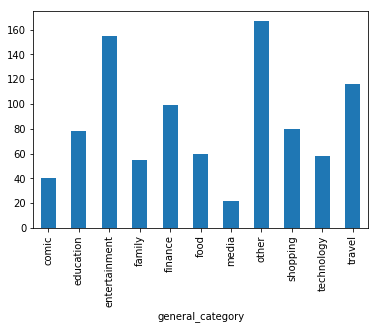

In [59]:
label_categories.groupby('general_category').size().plot(kind='bar')

### Merge/load app category information into a new dataframe with every app ID

In [60]:
# merge the new information into a new dataframe with app_ids 
app_categories = app_labels.merge(label_categories[['label_id','general_category']],
                                  on='label_id').drop('label_id',axis=1)

In [64]:
display(app_categories.head())

,app_id,general_category
0,7324884708820027918,finance
1,-4494216993218550286,finance
2,8756705988821000489,finance
3,1061207043315821111,finance
4,-1491198667294647703,finance


In [42]:
#app_events = app_events.merge(app_categories, on='app_id')

In [68]:
app_events.drop('is_installed', inplace=True, axis=1) # is installed is 1 for every app id

In [71]:
app_events

,event_id,app_id,is_active
0,2,5927333115845830913,1
1,2,-5720078949152207372,0
2,2,-1633887856876571208,0
3,2,-653184325010919369,1
4,2,8693964245073640147,1
...,...,...,...
32473062,3252948,6607018907660377991,1
32473063,3252948,6602285879264922467,1
32473064,3252948,4348659952760821294,1
32473065,3252948,-995726944612374565,1


### Create Device_ID Features from App info:

In [ ]:
# cast the categories into columns...

In [72]:
event_counts = app_events.groupby('event_id').agg({'app_id': 'count', 'is_active': 'sum'}).rename(
    columns = {'app_id': 'total_apps', 'is_active': 'active_apps'}).reset_index(col_level=1) 
# col-level lets you take both columns produced by groupby
event_counts

,event_id,total_apps,active_apps
0,2,19,6
1,6,38,15
2,7,40,13
3,9,35,7
4,16,31,1
...,...,...,...
1488091,3252935,14,14
1488092,3252936,3,3
1488093,3252937,19,19
1488094,3252946,69,25


In [73]:
event_counts['proportion_active'] = event_counts.apply(lambda x: x['active_apps']/x['total_apps'], axis=1)

In [74]:
event_counts

,event_id,total_apps,active_apps,proportion_active
0,2,19,6,0.315789
1,6,38,15,0.394737
2,7,40,13,0.325000
3,9,35,7,0.200000
4,16,31,1,0.032258
...,...,...,...,...
1488091,3252935,14,14,1.000000
1488092,3252936,3,3,1.000000
1488093,3252937,19,19,1.000000
1488094,3252946,69,25,0.362319


In [176]:
app_features = event_counts.groupby('device_id')[['total_apps','active_apps','proportion_active']].mean()

,event_id,total_apps,active_apps,proportion_active
0,2,19,6,0.315789
1,6,38,15,0.394737
2,7,40,13,0.325000
3,9,35,7,0.200000
4,16,31,1,0.032258
...,...,...,...,...
1488091,3252935,14,14,1.000000
1488092,3252936,3,3,1.000000
1488093,3252937,19,19,1.000000
1488094,3252946,69,25,0.362319


### Examine time of day data from all app info:

In [297]:
# event_counts_all is all event count (e.g. installed apps/active apps per event) info merged into 
# original events data frame
event_counts_all = event_counts.merge(events, on='event_id')

In [298]:
event_counts_all['hour_of_day'] = event_counts_all.timestamp.dt.hour

In [299]:
# sort the event entries by hour of day
event_counts_all = event_counts_all.sort_values(by='hour_of_day')

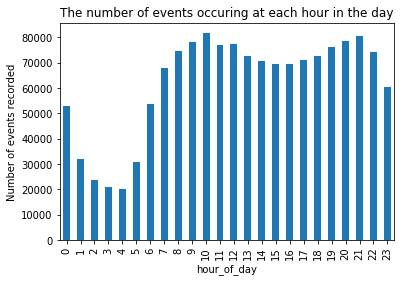

In [300]:
ax = event_counts_all.groupby('hour_of_day').size().plot(kind='bar')
ax.set_title('The number of events occuring at each hour in the day')
ax.set_ylabel('Number of events recorded')
plt.show()

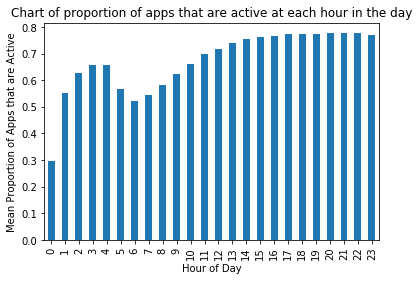

In [251]:
ax = event_counts_all.groupby('hour_of_day')['proportion_active'].mean().plot(kind='bar')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Proportion of Apps that are Active')
ax.set_title('Chart of proportion of apps that are active at each hour in the day')
plt.show()

In [139]:
event_counts_all

,event_id,total_apps,active_apps,proportion_active,device_id,timestamp,longitude,latitude,hour_of_day
0,2,19,6,0.315789,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,0
417933,913587,52,2,0.038462,-7001142643807111407,2016-05-01 00:31:00,0.00,0.00,0
417932,913586,46,8,0.173913,-3620610201417112380,2016-05-01 00:32:42,0.00,0.00,0
417931,913582,43,2,0.046512,-3840415774637608184,2016-05-01 00:46:21,110.30,25.26,0
417930,913580,33,16,0.484848,1977050826073860214,2016-05-01 00:00:22,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...
945176,2065519,7,7,1.000000,-4760257939216791047,2016-05-07 23:11:33,0.00,0.00,23
945175,2065518,7,7,1.000000,6281313989192504493,2016-05-07 23:13:07,125.28,43.83,23
945174,2065517,1,1,1.000000,3869397168225281448,2016-05-07 23:10:02,104.00,30.00,23
945185,2065537,2,2,1.000000,3871020928138962485,2016-05-07 23:34:35,0.00,0.00,23


In [246]:
events_sample = event_counts_all[event_counts_all.device_id == 29182687948017175]

In [247]:
events_sample = events_sample.sort_values(by='timestamp')

In [248]:
events_sample

,event_id,total_apps,active_apps,proportion_active,device_id,timestamp,longitude,latitude,hour_of_day
681962,1491059,43,9,0.209302,29182687948017175,2016-05-01 00:17:33,121.38,31.24,0
417910,913537,43,9,0.209302,29182687948017175,2016-05-01 00:22:12,121.38,31.24,0
218262,477452,10,10,1.000000,29182687948017175,2016-05-01 01:23:49,121.38,31.24,1
978865,2139311,10,10,1.000000,29182687948017175,2016-05-01 01:24:16,121.38,31.24,1
1278034,2793954,9,9,1.000000,29182687948017175,2016-05-01 02:23:48,121.38,31.24,2
...,...,...,...,...,...,...,...,...,...
991618,2166807,9,9,1.000000,29182687948017175,2016-05-07 20:00:26,121.38,31.24,20
244374,534263,15,15,1.000000,29182687948017175,2016-05-07 20:09:05,0.00,0.00,20
874648,1911116,13,13,1.000000,29182687948017175,2016-05-07 22:08:17,0.00,0.00,22
457165,1000218,16,16,1.000000,29182687948017175,2016-05-07 22:09:10,121.38,31.24,22


In [245]:
event_counts_all[event_counts_all.device_id == -6401643145415154744]

,event_id,total_apps,active_apps,proportion_active,device_id,timestamp,longitude,latitude,hour_of_day
0,2,19,6,0.315789,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,0
1390559,3040066,17,5,0.294118,-6401643145415154744,2016-05-02 00:10:05,103.62,30.99,0
729107,1593610,16,4,0.250000,-6401643145415154744,2016-05-04 00:46:33,0.00,0.00,0
658876,1440921,17,5,0.294118,-6401643145415154744,2016-05-04 00:43:54,103.64,30.97,0
908543,1985446,17,5,0.294118,-6401643145415154744,2016-05-02 00:13:02,103.64,30.97,0
29665,65269,19,6,0.315789,-6401643145415154744,2016-05-01 00:51:34,103.65,30.97,0
909250,1987062,4,4,1.000000,-6401643145415154744,2016-05-04 02:40:07,0.00,0.00,2
1043019,2279447,21,6,0.285714,-6401643145415154744,2016-05-01 04:16:29,0.00,0.00,4
358667,784503,7,7,1.000000,-6401643145415154744,2016-05-01 06:50:41,0.00,0.00,6
1423007,3111261,17,5,0.294118,-6401643145415154744,2016-05-05 09:40:16,110.55,19.73,9


In [219]:
levels_df = pd.DataFrame(event_counts_all.groupby(['longitude','latitude']).size()).rename(columns = {0: 'count'})

In [220]:
levels_df.reset_index(inplace=True)

In [253]:
import folium
from folium.plugins import HeatMap
def generateBaseMap(default_location=[31.24,121.38], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [262]:
base_map = generateBaseMap()

In [254]:
df_copy = levels_df[np.logical_and(levels_df.latitude > 0, levels_df.longitude > 0)].copy()
df_copy['count'] = 1

In [255]:
df_copy

,longitude,latitude,count
92,0.02,0.38,1
94,0.05,0.28,1
95,0.05,0.38,1
96,0.05,0.39,1
98,0.06,0.37,1
...,...,...,...
50489,139.43,35.62,1
50490,139.56,35.62,1
50491,139.68,35.83,1
50492,139.69,35.83,1


In [263]:
HeatMap(data=levels_df[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)



In [264]:
base_map

In [287]:
levels_sorted = levels_df.sort_values(by='count', ascending=False).reset_index(drop=True)

In [288]:
levels_sorted = levels_sorted.

,longitude,latitude,count
0,1.00,1.00,16158
1,104.00,30.00,5910
2,108.58,34.42,1477
3,104.51,35.52,1131
4,112.91,28.23,1039
...,...,...,...
50489,116.13,38.82,1
50490,116.13,38.74,1
50491,116.13,38.44,1
50492,116.13,33.91,1


In [284]:
m = folium.Map(location=[1,1], control_scale=True, zoom_start=12)

In [285]:
for index, row in levels_sorted.iloc[:100,:].iterrows():
    radius = row['count']/100
    color="#E37222" # tangerine
    
    folium.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius=radius,
                        color=color,
                        fill=True).add_to(m)

In [289]:
from folium.plugins import HeatMapWithTime


In [ ]:
m2 = generateBaseMap(default_zoom_start=11)

In [301]:
event_counts_clean = event_counts_all.copy()[(event_counts_all.longitude > 1) & (event_counts_all.latitude > 1)]

In [302]:
event_counts_clean['count'] = 1

In [303]:
event_counts_clean

,event_id,total_apps,active_apps,proportion_active,device_id,timestamp,longitude,latitude,hour_of_day,count
0,2,19,6,0.315789,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,0,1
417931,913582,43,2,0.046512,-3840415774637608184,2016-05-01 00:46:21,110.30,25.26,0,1
417928,913577,49,12,0.244898,-4795868253486304265,2016-05-01 00:17:45,106.54,29.53,0,1
417926,913574,16,2,0.125000,-2604948078979367841,2016-05-01 00:02:27,108.96,34.33,0,1
417934,913588,43,4,0.093023,-8968369310542461421,2016-05-01 00:27:00,116.42,39.95,0,1
...,...,...,...,...,...,...,...,...,...,...
945187,2065539,60,18,0.300000,-7494635710766739667,2016-05-07 23:03:56,113.29,23.05,23,1
945182,2065531,31,10,0.322581,-3707634941855233533,2016-05-07 23:08:55,122.07,41.00,23,1
945175,2065518,7,7,1.000000,6281313989192504493,2016-05-07 23:13:07,125.28,43.83,23,1
945174,2065517,1,1,1.000000,3869397168225281448,2016-05-07 23:10:02,104.00,30.00,23,1


In [ ]:
df_hour_list = []
for hour in event_counts_clean.hour_of_day.unique():
    hour_df = event_counts_clean.loc[event_counts_clean.hour_of_day == hour,:].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist()
    
    #hour_df = pd.DataFrame(event_counts_clean.loc[event_counts_clean.hour_of_day == hour,:].groupby(['longitude','latitude']).size()).rename(columns = {0: 'count'})
    df_hour_list.append(hour_df.groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
    df_hour_list = event_counts_clean.loc[event_counts_clean.hour_of_day == hour,['latitude','longitude']]
    
    
df_hour_list = []
for hour in event_counts_clean.hour_of_day.unique():
    df_hour_list.append(event_counts_clean.loc[event_counts_clean.hour_of_day == hour,
                                               ['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())



In [ ]:
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)

# Creating a reference table that gathers the informations in the multiples tables

Merge the tables into one general table so we can access the data more easily

In [13]:
complete_ref_table = app_events
complete_ref_table = complete_ref_table.merge(app_labels, on = "app_id")
complete_ref_table = complete_ref_table.merge(label_categories, on = "label_id")
del complete_ref_table['is_installed']  # I dont think is_installed adds any information
complete_ref_table = complete_ref_table.merge(events, on="event_id")
complete_ref_table = complete_ref_table.merge(brand_df, on="device_id")
complete_ref_table = complete_ref_table[["event_id", "app_id", "label_id", "category", "device_id", "phone_brand", "device_model", "timestamp", "longitude", "latitude", "is_active"]]

display(complete_ref_table.head())

,event_id,app_id,label_id,category,device_id,phone_brand,device_model,timestamp,longitude,latitude,is_active
0,2,5927333115845830913,549,Property Industry 1.0,-6401643145415154744,三星,Galaxy Grand Prime,2016-05-01 00:54:12,103.65,30.97,1
1,2,8693964245073640147,549,Property Industry 1.0,-6401643145415154744,三星,Galaxy Grand Prime,2016-05-01 00:54:12,103.65,30.97,1
2,2,4775896950989639373,549,Property Industry 1.0,-6401643145415154744,三星,Galaxy Grand Prime,2016-05-01 00:54:12,103.65,30.97,1
3,2,-8022267440849930066,549,Property Industry 1.0,-6401643145415154744,三星,Galaxy Grand Prime,2016-05-01 00:54:12,103.65,30.97,0
4,2,9112463267739110219,549,Property Industry 1.0,-6401643145415154744,三星,Galaxy Grand Prime,2016-05-01 00:54:12,103.65,30.97,0


# Creating training set

Once we have this reference table we can build our training set, assigning to every entry of that table the corresponding age and gender for the user

In [14]:
# Build training set
train_set = (complete_ref_table.merge(gender_age_train, on="device_id")).head(3500000)
test_set = complete_ref_table.merge(gender_age_train, on="device_id").tail(200000)
test_set.head()

,event_id,app_id,label_id,category,device_id,phone_brand,device_model,timestamp,longitude,latitude,is_active,gender,age,group
2294132,69857,33792862810792679,252,Wealth Management,-8649941211508968787,小米,红米,2016-05-04 00:20:57,0.0,0.0,1,M,62,M39+
2294133,69857,3683147815759994238,252,Wealth Management,-8649941211508968787,小米,红米,2016-05-04 00:20:57,0.0,0.0,1,M,62,M39+
2294134,69857,6965654211116534216,252,Wealth Management,-8649941211508968787,小米,红米,2016-05-04 00:20:57,0.0,0.0,0,M,62,M39+
2294135,69857,6965654211116534216,761,Financial Services,-8649941211508968787,小米,红米,2016-05-04 00:20:57,0.0,0.0,0,M,62,M39+
2294136,69857,502665604573257504,761,Financial Services,-8649941211508968787,小米,红米,2016-05-04 00:20:57,0.0,0.0,1,M,62,M39+
